In [1]:
from init import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

autotime loaded.


In [2]:
class Sampling(layers.Layer):
    def call(self, inputs):
        zmean, z_log_var = inputs
        batch = tf.shape(zmean)[0]
        dim = tf.shape(zmean)[1]
        eps = keras.backend.random_normal(shape=(batch, dim))
        new = zmean + eps * tf.exp(0.5 * z_log_var)
        return new

time: 1.58 ms


In [3]:
class Plot():
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def plot_latent(self):
        n = 30
        digit_size = 28
        scale = 2.0
        figsize = 15
        figure = np.zeros((digit_size * n, digit_size * n))

        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = self.decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.show()

    def plot_label_clusters(self, data, labels):
        z_mean, _, _ = self.encoder.predict(data)
        plt.figure(figsize=(12, 10))
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()

time: 5.57 ms


In [4]:
input_shape = (28, 28, 1)
latent_dim = 2
depth = 32
kernel_size = 3
strides = 2

time: 42.5 ms


In [5]:
# Encoder
encoder_input = keras.Input(shape=input_shape, name='encoder_input')
x = encoder_input
for i in [1, 2]:
    x = layers.Conv2D(i*depth, kernel_size, activation="relu", strides=strides, padding="same")(x)
_, sh1, sh2, sh3 = keras.backend.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling(name='sampling')([z_mean, z_log_var])
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
___________

In [6]:
# Decoder
latent_input = keras.Input(shape=(latent_dim, ))
x = layers.Dense(sh1 * sh2 * sh3, activation='relu')(latent_input)
x = layers.Reshape((sh1, sh2, sh3))(x)

for i in [2, 1]:
    x = layers.Conv2DTranspose(i * depth, kernel_size, activation='relu', strides=strides, padding='same')(x)
output = layers.Conv2DTranspose(1, kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)
decoder = keras.Model(latent_input, output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [7]:
z = encoder(encoder_input)[2]
output = decoder(z)
vae = keras.Model(encoder_input, output, name='Variational AutoEncoder')
reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(encoder_input, output))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
total_loss = reconstruction_loss + kl_loss
vae.add_loss([total_loss, reconstruction_loss, kl_loss])
vae.compile(optimizer='adam')
vae.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Variational AutoEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    65089       encoder[1][2]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3136)         9408        encoder[1][2]   

In [8]:
(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
vae.fit(x_train, epochs=30, batch_size=128)
# vae.fit(mnist_digits, epochs=30, batch_size=128)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 76s 1ms/sample - loss: 444.8700
Epoch 2/30
60000/60000 [==============================] - 74s 1ms/sample - loss: 382.0587
Epoch 3/30
60000/60000 [==============================] - 76s 1ms/sample - loss: 370.7281
Epoch 4/30
60000/60000 [==============================] - 72s 1ms/sample - loss: 365.4665
Epoch 5/30
60000/60000 [==============================] - 72s 1ms/sample - loss: 362.2886
Epoch 6/30
60000/60000 [==============================] - 70s 1ms/sample - loss: 359.3271
Epoch 7/30
60000/60000 [==============================] - 73s 1ms/sample - loss: 356.4964
Epoch 8/30
60000/60000 [==============================] - 82s 1ms/sample - loss: 353.8998
Epoch 9/30
60000/60000 [==============================] - 81s 1ms/sample - loss: 351.7098
Epoch 10/30
60000/60000 [==============================] - 75s 1ms/sample - loss: 349.9875
Epoch 11/30
60000/60000 [==============================] - 75s 1ms/sample - 

time: 37min 46s


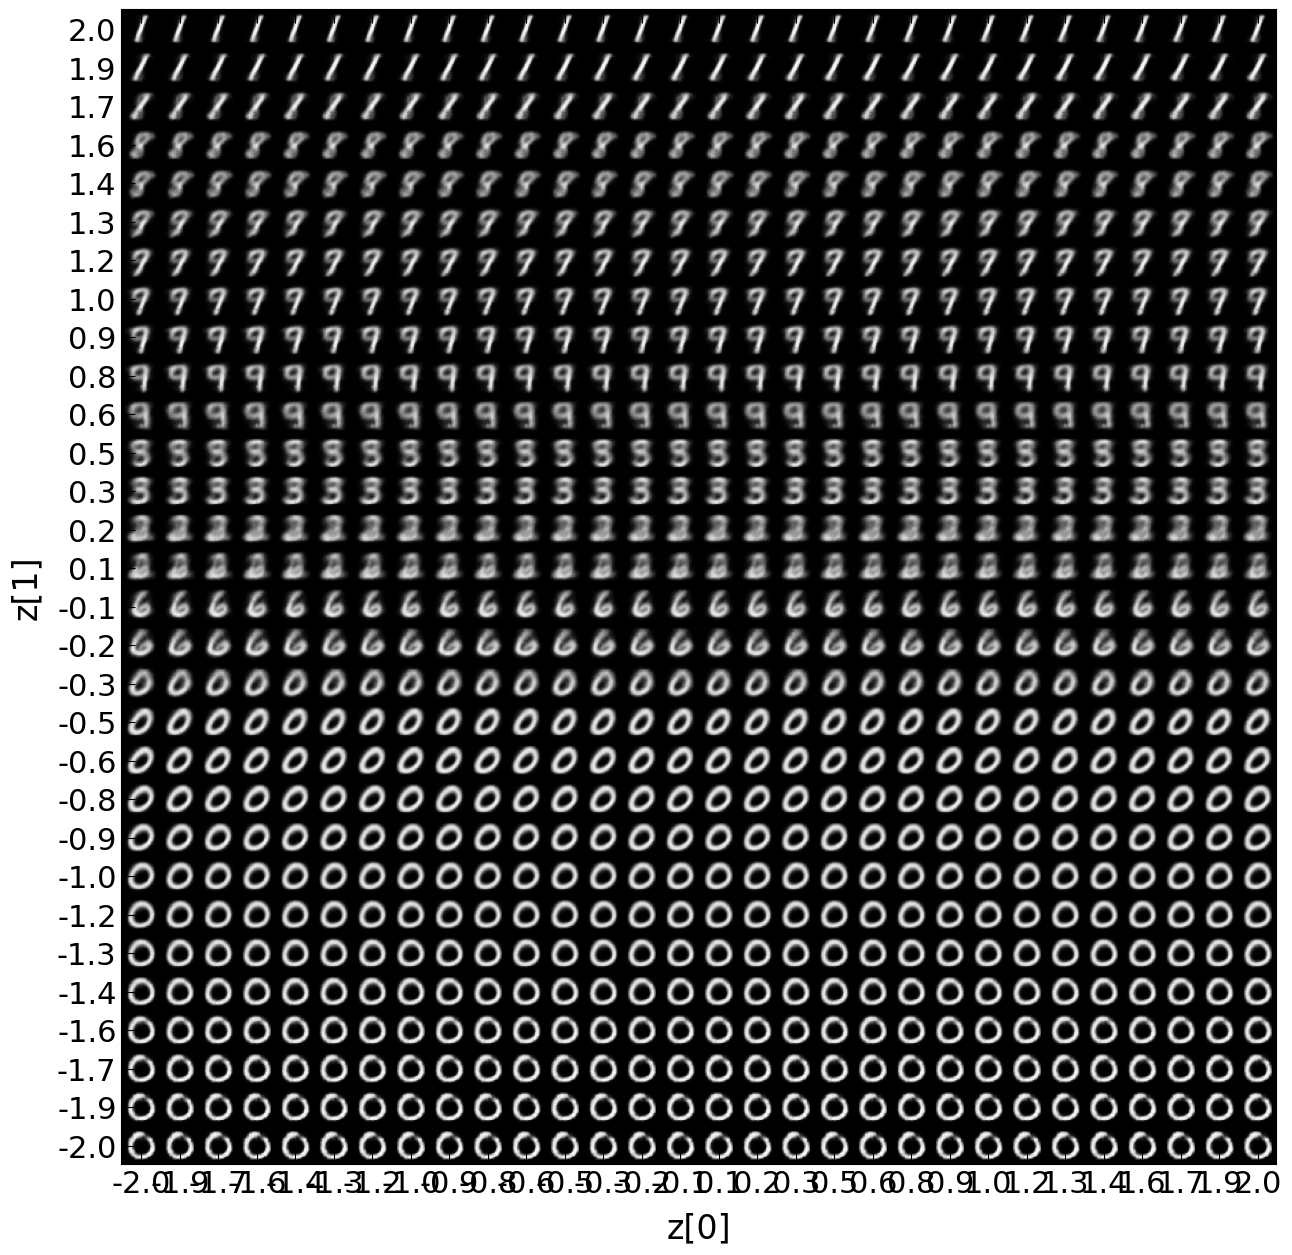

time: 3.43 s


In [9]:
plot = Plot(encoder, decoder)

# display a n*n 2D manifold of digits
plot.plot_latent()

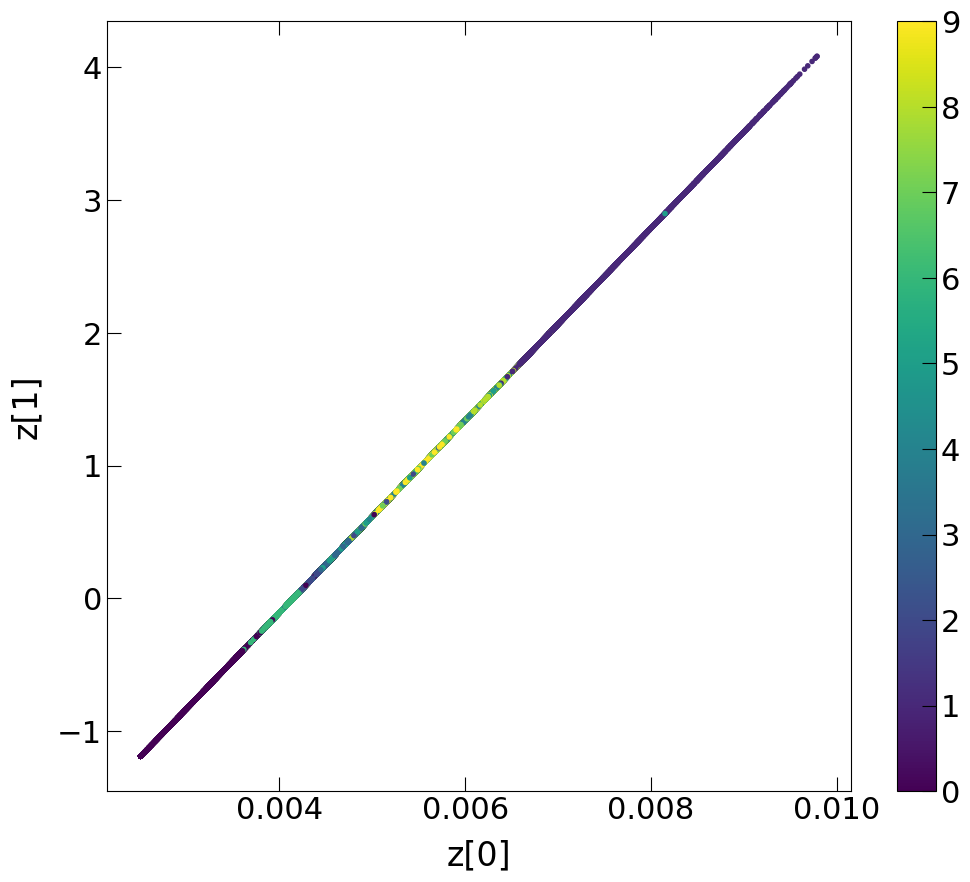

time: 6.95 s


In [10]:
# display a 2D plot of the digit classes in the latent space
plot.plot_label_clusters(x_train, y_train)